In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/heart_disease_dataset.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Rename target column to classify risk of suffering a heart attack and sex column

df = df.rename(columns={'target': 'risk',
                        'sex': 'gender'})
df.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,risk
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
# Confirm all columns are interger datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1888 non-null   int64  
 1   gender    1888 non-null   int64  
 2   cp        1888 non-null   int64  
 3   trestbps  1888 non-null   int64  
 4   chol      1888 non-null   int64  
 5   fbs       1888 non-null   int64  
 6   restecg   1888 non-null   int64  
 7   thalachh  1888 non-null   int64  
 8   exang     1888 non-null   int64  
 9   oldpeak   1888 non-null   float64
 10  slope     1888 non-null   int64  
 11  ca        1888 non-null   int64  
 12  thal      1888 non-null   int64  
 13  risk      1888 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 206.6 KB


In [5]:
# Unique values per column

df.nunique()

,0
age,41
gender,2
cp,5
trestbps,50
chol,152
fbs,2
restecg,3
thalachh,92
exang,2
oldpeak,40


In [6]:
df.isnull().sum()

,0
age,0
gender,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalachh,0
exang,0
oldpeak,0


In [7]:
# Age column displayed in descending order
## 50s is the dominate age group in dataset

ages = df['age'].value_counts().sort_values(ascending=False)

Text(0, 0.5, 'Number of Participants')

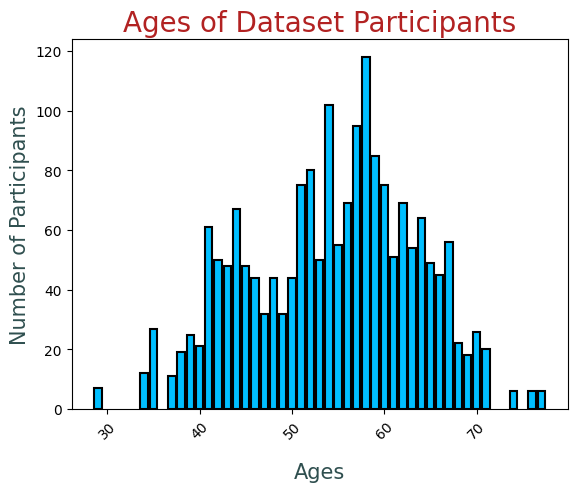

In [8]:
# Bar chart visualization of dataset's age column
# plotly

plt.bar(ages.index, ages, color="deepskyblue", align="center", edgecolor='k', linewidth=1.5)
plt.xticks(rotation=45, color="k")
plt.yticks(color="k")
plt.title("Ages of Dataset Participants", fontsize=20, color='firebrick')
plt.xlabel('Ages', fontsize=15, color='darkslategray', labelpad=15)
plt.ylabel('Number of Participants', fontsize=15, color='darkslategray')

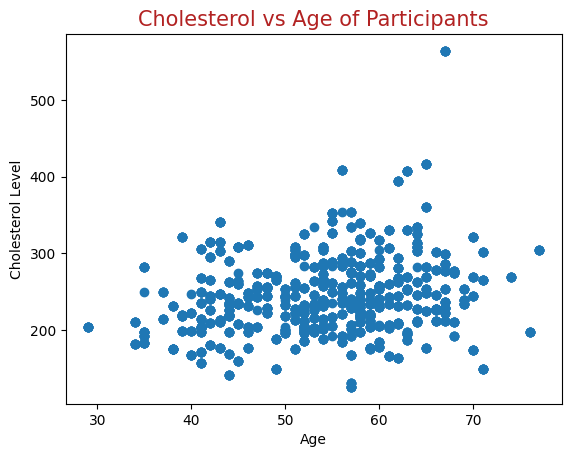

In [9]:
# Scatterplot to check cholesterol column for outliers
# plotly

## Data appears appropriately grouped




# correlation_line = round(st.pearsonr(df["chol"], df["age"])[0],2)
# model = st.linregress(df["chol"], df["age"])

# # model just has two points, start and end, 0 and 1, NOT SAME AS SCIPY
# values = df["chol"]*model[0]+model[1]
# plt.plot(df["age"], values, color="red")






plt.scatter(df["age"], df["chol"])
plt.xlabel("Age")
plt.ylabel("Cholesterol Level")
plt.title("Cholesterol vs Age of Participants", fontsize=15, color='firebrick')
plt.show()

In [10]:
# Gender column value count
# 1 = Male, 0 = Female

## Possible bias
## Dataset is heavily weighed towards males

genders = df['gender'].value_counts()
genders

,count
gender,
1,1300
0,588


<Axes: title={'center': 'Gender of Dataset Participants'}, xlabel='1 = Male           0 = Female', ylabel=' '>

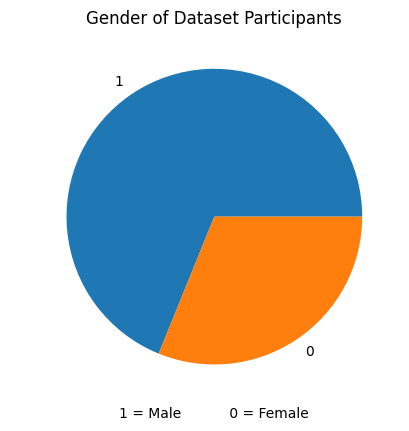

In [11]:
# Pie chart visualization of gender column's unbalanced data
# pandas chart

chart = genders.plot(kind="pie", title="Gender of Dataset Participants")
chart.set_xlabel("1 = Male           0 = Female")
chart.set_ylabel(" ")
chart

In [12]:
# Fasting blood sugar (fbs) > 120 mg/dl
# 1 = true, 0 = false.

## Possible bias
## Large majority of dataset have fbs above 120 mg/dl

fbs = df['fbs'].value_counts()
fbs

,count
fbs,
0,1608
1,280


<Axes: title={'center': 'Fast Blood Sugar > 120 mg/dl'}, xlabel='1 = Above 120           0 = Below 120', ylabel=' '>

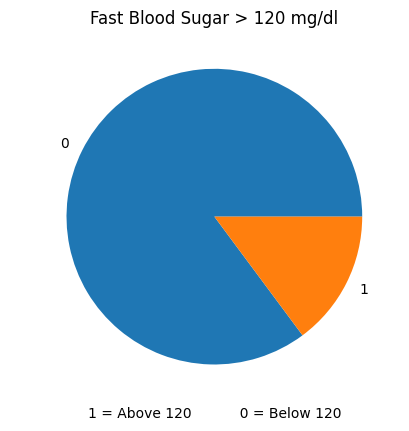

In [13]:
# Pie chart visualization of fbs column's unbalanced data
# pandas chart

chart = fbs.plot(kind="pie", title="Fast Blood Sugar > 120 mg/dl")
chart.set_xlabel("1 = Above 120           0 = Below 120")
chart.set_ylabel(" ")
chart

In [14]:
# Risk of a heart attack
# 1 = risk, 0 = not at risk
## Near even split in data. Good to use as target column

risk = df['risk'].value_counts()

<Axes: title={'center': 'Likelyhood of Heart Attack'}, xlabel='1 = At Risk           0 = Not Likely', ylabel='Number of Participants'>

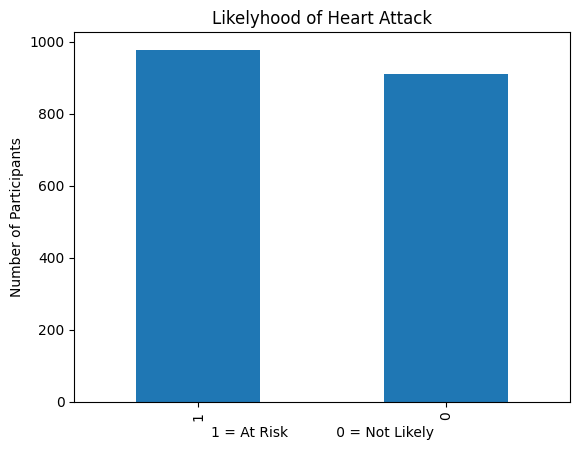

In [15]:
# Bar chart visualization of risk column's balanced data
# pandas chart

chart = risk.plot(kind="bar", title="Likelyhood of Heart Attack")
chart.set_xlabel("1 = At Risk           0 = Not Likely")
chart.set_ylabel("Number of Participants")
chart


In [20]:
# Split our preprocessed data into our features and target arrays
copy_df = df.copy()
y = copy_df['risk'].values
X= copy_df.drop(['risk'], axis='columns').values


# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [22]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()
input_layers = len(X_train[0])

## 2/3 rule of number of columns(features) it's reshaped into
hidden_layer_1 = 120
hidden_layer_2 = 60
hidden_layer_3 = 30
# hidden_layer_4 = 15
# hidden_layer_5 = 7

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_1, activation="relu", input_dim=input_layers))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_3, activation="relu"))

# # Fourth hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_layer_3, activation="relu"))

# # Fifth hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_layer_3, activation="relu"))

# Output layer - sigmoid with used with binary data
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 120)                 │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 60)                  │           7,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,801 (42.19 KB)

 Trainable params: 10,801 (42.19 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [24]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6721 - loss: 0.6249
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8198 - loss: 0.4243
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8222 - loss: 0.3765
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8593 - loss: 0.3213
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8782 - loss: 0.2774
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9104 - loss: 0.2283
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9229 - loss: 0.1976
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9317 - loss: 0.1797
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9523 - loss: 0.1492
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9594 - loss: 0.1323
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9651 - loss: 0.1118
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [25]:
# Evaluate the model using training data
model_loss, model_accuracy = nn.evaluate(X_train_scaled,y_train,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

45/45 - 0s - 5ms/step - accuracy: 1.0000 - loss: 8.0410e-05
Loss: 8.041020919336006e-05, Accuracy: 1.0


In [26]:
# Evaluate the model using test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

15/15 - 0s - 4ms/step - accuracy: 0.9597 - loss: 0.3616
Loss: 0.36159271001815796, Accuracy: 0.9597457647323608


In [27]:
# Export our model to HDF5 file
nn.save('AlphabetSoupCharity.h5')

## Loading and Preprocessing Heart Attack Encoded Data

In [28]:
X = df.copy()
X.drop("risk", axis=1, inplace=True)
X.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [29]:
y = df["risk"].ravel()
y[:5]

<ipython-input-29-d9eb575b8984>:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = df["risk"].ravel()


array([1, 1, 1, 1, 1])

In [30]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=500)

In [31]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [32]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [33]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Fitting the Random Forest Model

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [36]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

## Making Predictions Using the Random Forest Model

In [37]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

## Random Forest Model Evaluation

In [38]:
# Calculating the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [39]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,223,6
Actual 1,8,235


Accuracy Score : 0.9703389830508474
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       229
           1       0.98      0.97      0.97       243

    accuracy                           0.97       472
   macro avg       0.97      0.97      0.97       472
weighted avg       0.97      0.97      0.97       472



## Feature Importance

In [40]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.14198435449474156, 'thal'),
 (0.13793167467035417, 'cp'),
 (0.1008905016891258, 'thalachh'),
 (0.09382485966494421, 'oldpeak'),
 (0.08565003848466117, 'age'),
 (0.08452910104379899, 'slope'),
 (0.08295417492584131, 'chol'),
 (0.08270083466333168, 'ca'),
 (0.07401102518489844, 'trestbps'),
 (0.03902665880511431, 'restecg'),
 (0.03514416690898482, 'exang'),
 (0.030629868649516515, 'gender'),
 (0.01072274081468715, 'fbs')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

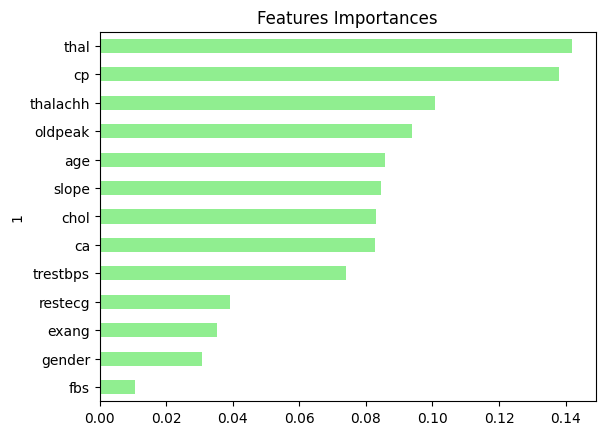

In [41]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

## Fitting the Decision Tree Model

In [42]:
# Creating the decision tree classifier instance
from sklearn import tree
model = tree.DecisionTreeClassifier()

In [43]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

## Making Predictions Using the Tree Model

In [44]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

## Decision Tree Model Evaluation

In [45]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [46]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,221,8
Actual 1,10,233


Accuracy Score : 0.961864406779661
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       229
           1       0.97      0.96      0.96       243

    accuracy                           0.96       472
   macro avg       0.96      0.96      0.96       472
weighted avg       0.96      0.96      0.96       472



## Preparing Data for K

In [47]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
heart_data_scaled = StandardScaler().fit_transform(df)

In [48]:
# Create a DataFrame with the scaled data
df_heart_scaled = pd.DataFrame(
    heart_data_scaled)

df_heart_scaled.columns = df.columns

# Display the scaled DataFrame
df_heart_scaled.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,risk
0,0.952259,0.672538,1.343864,0.766322,-0.268538,2.396426,-0.935500,0.025032,-0.70430,1.073386,-2.295053,-0.720321,-1.330518,0.965633
1,-1.911461,0.672538,0.562942,-0.088265,0.060947,-0.417288,0.630301,1.633724,-0.70430,2.106945,-2.295053,-0.720321,-0.530257,0.965633
2,-1.470888,-1.486904,-0.217980,-0.088265,-0.830601,-0.417288,-0.935500,0.981551,-0.70430,0.298216,0.933755,-0.720321,-0.530257,0.965633
3,0.181258,0.672538,-0.217980,-0.657990,-0.210394,-0.417288,0.630301,1.242420,-0.70430,-0.218564,0.933755,-0.720321,-0.530257,0.965633
4,0.291401,-1.486904,-0.998902,-0.657990,2.076620,-0.417288,0.630301,0.590248,1.41985,-0.390824,0.933755,-0.720321,-0.530257,0.965633


## Find the Best Value for k Using the Original Scaled DataFrame.


In [50]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
!pip install panel hvplot
import hvplot.pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 3.6 MB/s eta 0:00:00


In [51]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

In [52]:
# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
for i in k:
    # Inside the loop:
    # 1. Create a KMeans model using the loop counter for the n_clusters
    k_model = KMeans(n_clusters=i, random_state=0)
    # 2. Fit the model to the data using `df_market_data_scaled`
    k_model.fit(df_heart_scaled)
    # 3. Append the model.inertia_ to the inertia list
    inertia.append(k_model.inertia_)

In [53]:
# Create a dictionary with the data to plot the Elbow curve
scaled_elbow_data = {"k": k, "inertia": inertia}

# Create a DataFrame with the data to plot the Elbow curve
df_scaled_elbow = pd.DataFrame(scaled_elbow_data)

In [54]:
# Plot a line chart with all the inertia values computed with
# the different values of k to visually identify the optimal value for k.
scaled_elbow_curve = df_scaled_elbow.hvplot.line(
    x="k",
    y="inertia",
    title="Scaled Elbow Curve",
    xticks=k
)

scaled_elbow_curve

:Curve   [k]   (inertia)

## Cluster Cryptocurrencies with K-means Using the Original Scaled DataFrame

In [55]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=7, random_state=0)

In [56]:
# Fit the K-Means model using the scaled DataFrame
model.fit(df_heart_scaled)

KMeans(n_clusters=7, random_state=0)

In [57]:
# Predict the clusters to group the cryptocurrencies using the scaled DataFrame
heart_clusters = model.predict(df_heart_scaled)

# Print the resulting array of cluster values.
print(heart_clusters)

[3 0 0 ... 2 2 1]


In [58]:
# Create a copy of the scaled DataFrame
df_heart_scaled_predictions = df_heart_scaled.copy()

In [59]:
# Add a new column to the copy of the scaled DataFrame with the predicted clusters
df_heart_scaled_predictions["HeartCluster"] = heart_clusters

# Display the copy of the scaled DataFrame
df_heart_scaled_predictions.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,risk,HeartCluster
0,0.952259,0.672538,1.343864,0.766322,-0.268538,2.396426,-0.935500,0.025032,-0.70430,1.073386,-2.295053,-0.720321,-1.330518,0.965633,3
1,-1.911461,0.672538,0.562942,-0.088265,0.060947,-0.417288,0.630301,1.633724,-0.70430,2.106945,-2.295053,-0.720321,-0.530257,0.965633,0
2,-1.470888,-1.486904,-0.217980,-0.088265,-0.830601,-0.417288,-0.935500,0.981551,-0.70430,0.298216,0.933755,-0.720321,-0.530257,0.965633,0
3,0.181258,0.672538,-0.217980,-0.657990,-0.210394,-0.417288,0.630301,1.242420,-0.70430,-0.218564,0.933755,-0.720321,-0.530257,0.965633,0
4,0.291401,-1.486904,-0.998902,-0.657990,2.076620,-0.417288,0.630301,0.590248,1.41985,-0.390824,0.933755,-0.720321,-0.530257,0.965633,5


In [60]:
# Create a scatter plot using hvPlot by setting
scaled_clusters = df_heart_scaled_predictions.hvplot.scatter(
    x="thal",
    y="cp",
    by="HeartCluster",
    title = "Scaled Cluster"
)

scaled_clusters

:NdOverlay   [HeartCluster]
   :Scatter   [thal]   (cp)